# All the plots and slices 

In [63]:
import numpy as np
import nibabel as nib
from nilearn import plotting
import nilearn as ni
from scipy import ndimage
# custom colormap imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
import os
import fnmatch
import json
import plotting as myplt

%matplotlib inline

### Setup Constants and Variables

In [64]:
# setup custom colormap 
alpha = 0.5
active = (0.95, 0.9, 0.25, 1.0) # yellow
necrosis = (0.8, 0.4, 0, 1.0) #kinda red/orange
edema = (0, 0.6, 0.5, 1.0) # bluish green

In [65]:
# individual colormaps for single plots
edm = myplt.binaryCMap(edema)
atm = myplt.binaryCMap(active)
necm = myplt.binaryCMap(necrosis)

#### Input folder layout requirements:
##### INGEST_GT (= Ground Truth)
- Dir: patname 
    - gt.nii
    
##### INGEST_RAW (raw images)
- Dir: patname
    - fla.nii
    - t1.nii
    - t1c.nii
    - t2.nii
    
##### INGEST_SEGS (segmentation candidates)
- Dir: patname
    - Dir: algorithm 
        - segmentation*.nii
    - Dir: algorithm
        - segmentation*.nii
    - Dir: fusion
        - simple_fusion.nii.gz (if automatic slice selection is needed
    

In [66]:
slicerMode = True
# setup constants
INGEST_GT = '/Users/christoph/Downloads/selection/'
INGEST_RAW = '/Users/christoph/Downloads/selection/'
INGEST_SEGS = '/Users/christoph/Downloads/selection/'
EXPORT_DIR = '/Users/christoph/Downloads/export/'

# The testdir contains only a single case
testdir = False

if testdir:
    INGEST_GT = '../single_test/results'
    INGEST_RAW = '../single_test/results'
    INGEST_SEGS = '../single_test/results'
    EXPORT_DIR = '../single_test/results/output'
    
# standard error message for folder creation
errormsg = 'Export directory already exists and will be overwritten!'

# black background
bg = True

# exported slices: max tumor area (axial): ma, max edema only slice (axial): ed, max tumor core (ax): tc
export_dirs = ['ax', 'sag', 'cor']
if not slicerMode:
    export_dirs = ['ma', 'ed', 'tc']
algorithms = ['rnd']

# debug flag for happy debugging (fixed slices, debug output and much more)
debug = False


### Function definitions

Unfinished: Slice selection

In [67]:
# find most interesting slice for png export
def findSlices(SEG):
    segm = ni.image.load_img(SEG)
    np_seg = segm.get_data()
    max = 0
    slice = 0
    whole = 0
    core = 0
    edema = 0
    # change this to match the dataset best
    backup = 85
    
    # find maximum core slice
    for i in range(np_seg.shape[2]):
        if (np.sum(np.where((np_seg[:][:][i] == 4) | np_seg[:][:][i] == 1)) > max):
            max = np.sum(np.where((np_seg[:][:][i] == 4) | np_seg[:][:][i] == 1))
            core = i
    # contingency case
    if (core > 120 or core < 50):
        core = backup

    #find maximum whole tumor slice
    min = (255*255)
    for i in range(np_seg.shape[2]):
        if (np.sum(np.where((np_seg[:][:][i] == 0))) < min):
            min = np.sum(np.where((np_seg[:][:][i] == 0)))
            whole = i
    # contingency case
    if (whole > 120 or whole < 50):
        whole = backup
    
    #find maximum edema voxel count without tumor core or active tumor voxels
    max = 0
    for i in range(np_seg.shape[2]):
        if (np.sum(np.where((np_seg[:][:][i] == 2))) > max and np.sum(np.where((np_seg[:][:][i] == 4) | np_seg[:][:][i] == 1)) == 0):
            max = np.sum(np.where((np_seg[:][:][i] == 1)))
            edema = i
    # contingency case
    if (edema > 120 or edema < 50):
        edema = backup
        
    # set cut locations for export
    if not debug:
        slices = {
            'tc': core,
            'ed': edema,
            'ma': whole
        }
    else:
        slices = {
            'tc': 95,
            'ed': 100,
            'ma': 105
        }
    return slices

In [68]:
def dirMaker(export_dir, patid, algorithm):
    for cut in export_dirs:
        folder = os.path.join(export_dir, patid+'_'+algorithm+'_'+cut)
        try:
            os.makedirs(folder)
        except:
            print(errormsg)
        try:
            os.makedirs(os.path.join(folder, 'normal'))
        except:
            print(errormsg)
        try: 
            os.makedirs(os.path.join(folder, 'segmented'))
        except:
            print(errormsg)

In [69]:
# import the modalities for a given patient (exam)
def modImporter(rawDir, patid):
    exam = os.path.join(rawDir, patid)
    modalities = {
        't1': os.path.join(exam, patid+ '_t1.nii.gz'),
        't1c': os.path.join(exam, patid+ '_t1c.nii.gz'),
        'fla': os.path.join(exam, patid+ '_fla.nii.gz'),
        't2':os.path.join(exam, patid+ '_t2.nii.gz')
    }
    return modalities
    

In [70]:
# Nibabel reshaped version
def patExport_nib(segmentation, exportPath, slices, modalities, algo, patid):
    # setup dictionary for json info file setup 
    data = {
        'algorithm-id': algo,
        'patient-id': patid,
        'location': '',
        'export-path': exportPath,
        'maxarea-slice': slices['ma'],
        'core-slice': slices['tc'],
        'edema-slice': slices['ed'],
        'colormap': {
            'edema': edema,
            'necrosis': necrosis, 
            'active': active,
            'alpha': 0.4
        }
    }
    # export slices with overlay
    for cut in slices.keys():
        temp = os.path.join(exportPath,patid+'_'+algo+'_'+cut)
        segmented = os.path.join(temp, 'segmented')
        normal = os.path.join(temp, 'normal')
        for modality in modalities.keys():
            # load img file 
            anat_img = nib.load(modalities[modality])
            anat_img_data = anat_img.get_fdata()
            # setup plot data 
            fig = plt.figure(frameon=False)
            plt.grid(b=None)
            plt.axis('off')
            #fig.set_dpi(200) #interpolates maybe!
            # plot raw image with appropriate transforms
            plt.annotate(modality, xy=(20,20), xytext=(30,30), color='white', size=14)
            raw = plt.imshow(np.flip(np.flip(np.rot90(anat_img_data[:,:,slices[cut]])),0), cmap=plt.cm.gray, origin='lower')
            # save without overlay
            plt.savefig(os.path.join(normal, patid+'_'+algo+'_'+cut+'_norm_'+modality+'.png'), transparent=True, bbox_inches='tight', pad_inches=0)
            # layer segmentation on top and save it
            ed = np.zeros(segmentation[:,:,slices[cut]].shape)
            nec = np.zeros(segmentation[:,:,slices[cut]].shape)
            act = np.zeros(segmentation[:,:,slices[cut]].shape)
            ed[segmentation[:,:,slices[cut]] == 2] = 1
            nec[segmentation[:,:,slices[cut]] == 1] = 1
            act[segmentation[:,:,slices[cut]] == 4] = 1
            im1 = plt.imshow(np.flip(np.flip(np.rot90(act)),0), cmap=atm, alpha=0.5, origin='lower')
            im2 = plt.imshow(np.flip(np.flip(np.rot90(ed)),0), cmap=edm, alpha=0.5, origin='lower')
            im3 = plt.imshow(np.flip(np.flip(np.rot90(nec)),0), cmap=necm, alpha=0.5, origin='lower')
            #seg = plt.imshow(np.flip(np.flip(np.rot90(segmentation[:,:,slices[cut]])),0)/5, alpha=alpha, cmap=cmap, norm=norm, origin='lower')
            plt.savefig(os.path.join(segmented, patid+'_'+algo+'_'+cut+'_seg_'+modality+'.png'), transparent=True, bbox_inches='tight', pad_inches=0)
            plt.clf()
            plt.close(fig)
        # add the cut location to the json and then dump it to file
        data['location'] = cut
        with open(os.path.join(temp, patid+'_data.json'), 'w') as f:
            json.dump(data, f)

In [71]:
verbose = True
patid = ''
export = []
# loop through exam folders and load the segmentations
for patient in os.listdir(INGEST_SEGS):
    patpath = os.path.join(INGEST_SEGS, patient)
    if not os.path.isdir(patpath):
        continue # Not a directory
    if 'brats' in patient:
        export.append(patient)
print(export)
print(len(export))

['brats_2013_pat0137_1', 'brats_2019_84_1', 'brats_2013_pat0116_1', 'brats_2019_80_1', 'brats_MDA_911_1', 'brats_cbica_patAAF_1', 'brats_MDA_934_1', 'brats_UAB_3458_1', 'brats_WashU_S035_1', 'brats_cbica_patATC_1', 'brats_cbica_patAMQ_1', 'brats_cbica_patAMG_1', 'brats_MDA_994_1', 'brats_cbica_patAOQ1_1', 'brats_cbica_patAAK_1', 'brats_MDA_916_1', 'brats_TMU_DC1_1', 'brats_2019_100_1', 'brats_cbica_patBGS_1', 'brats_MDA_947_1', 'brats_2019_88_1', 'brats_cbica_patBGA_1', 'brats_TMU_DC4_1', 'brats_cbica_patALP_1', 'brats_cbica_patAAN_1', 'brats_MDA_913_1', 'brats_cbica_patAMB_1', 'brats_MDA_904_1', 'brats_cbica_patBKX_1', 'brats_cbica_patANJ_1', 'brats_2019_66_1', 'brats_cbica_patAMS_1', 'brats_MDA_1018_1', 'brats_MDA_2003_1', 'brats_cbica_patAQK_1', 'brats_cbica_patAPS_1', 'brats_cbica_patBGF_1', 'brats_MDA_914_1', 'brats_WashU_W082_1', 'brats_cbica_patANR_1', 'brats_2013_pat0109_1', 'brats_cbica_patAUK_1']
42


In [72]:
def exportSlicesConventional():
    # main export loop
    for exam in export:
        # first find interesting slice using the fusion segmentation
        patpath = os.path.join(INGEST_SEGS, exam)
        gtpath = os.path.join(INGEST_GT, exam)
        # slicefinder now uses isensee because the labels are correct here
        slices = findSlices(os.path.join(gtpath, 'gt.nii'))
        if debug:
            print(slices)
        #create export folders
        for algo in algorithms:
            dirMaker(EXPORT_DIR, exam, algo)
        dirMaker(EXPORT_DIR, exam, 'gt')
        # load ground truth for export
        segpath = os.path.join(INGEST_GT, exam)
        gt = ni.image.load_img(os.path.join(segpath, 'gt.nii'))
        # load normal modalities
        modalities = modImporter(INGEST_RAW, exam)
        if debug:
            print(gt.header)
            print(t1c.header)
        gt = gt.get_fdata()
        patExport_nib(gt, EXPORT_DIR, slices, modalities, 'gt', exam)
        # load algorithm 1 (Isensee):
        segpath = os.path.join(patpath, 'results/tumor_isen2018_class.nii.gz')
        seg_img = nib.load(segpath)
        segmentation = seg_img.get_fdata()
        patExport_nib(segmentation, EXPORT_DIR, slices, modalities, 'ise', exam)
        # load algorithm 2 (Richard McKinley - DeepSCAN):
        segpath = os.path.join(patpath, 'results/tumor_DeepSCAN_class.nii.gz')
        seg_img = nib.load(segpath)
        segmentation = seg_img.get_fdata()
        patExport_nib(segmentation, EXPORT_DIR, slices, modalities, 'scan', exam)


In [73]:
def exportFolderList():
    # export folder list to json 
    exams = {
        'exams': os.listdir(EXPORT_DIR)
    }
    with open(os.path.join(EXPORT_DIR, 'directory.json'), 'w') as f:
        json.dump(exams, f)

exportFolderList()

## Center of Mass 3-way slice


In [76]:
planes = ('ax', 'sag', 'cor')
cube = (240,240,240)
padval = 5
# Plot images based on CoM of Tumor: axial, sagittal and coronal slice 
def plot_CoM(com, segmentation_orig, exportPath, modalities, algo, patid):
    """
    Plots and saves three slices that picture the three planes
    through the center of mass:
    * axial
    * sagittal
    * coronal
    
    saves the slices both with and without overlay, then dumps
    all relevant metadata to file
    """
        # setup dictionary for json info file setup 
    data = {
        'algorithm-id': algo,
        'patient-id': patid,
        'slices':{
            'axial': com[2],
            'sagittal': com[1],
            'coronal':com[0]
        },
        'export-path': exportPath,
        'center of mass': com,
        'shape': segmentation_orig.shape,
        'info': 'CoM in relation to the padded shape',
        'colormap': {
            'edema': edema,
            'necrosis': necrosis, 
            'active': active,
            'alpha': 0.4
        }
    }
    for plane in planes:
        temp = os.path.join(exportPath,patid+'_'+algo+'_'+plane)
        segmented = os.path.join(temp, 'segmented')
        normal = os.path.join(temp, 'normal')
        for modality in modalities.keys():
            # load img file 
            anat_img = nib.load(modalities[modality])
            #anat_img_data = padAx(anat_img.get_fdata(), cube)
            anat_img_data = myplt.pad3D(anat_img.get_fdata(),cube)
            rmin, rmax, cmin, cmax, zmin, zmax = bbox(anat_img_data)
            anat_img_data = anat_img_data[rmin:rmax,cmin:cmax, zmin:zmax]
            segmentation = segmentation_orig[rmin:rmax,cmin:cmax,zmin:zmax]
            # setup plot data 
            fig = plt.figure(frameon=False)
            plt.grid(b=None)
            plt.axis('off')
            #fig.set_dpi(200) #interpolates maybe!
            # plot raw image with appropriate transforms
            #plt.annotate(modality, xy=(20,20), xytext=(30,30), color='white', size=14)
            if plane is 'ax':
                raw = plt.imshow(np.flip(np.flip(np.rot90(np.pad(anat_img_data[:,:,com[2]-zmin], padval)),0)), cmap=plt.cm.gray, origin='lower')
            elif plane is 'cor':
                raw = plt.imshow(np.flipud(np.rot90(np.pad(anat_img_data[:,com[1]-cmin,:], padval))), cmap=plt.cm.gray, origin='lower')
            elif plane is 'sag':
                raw = plt.imshow(np.flipud(np.rot90(np.pad(anat_img_data[com[0]-rmin,:,:], padval))), cmap=plt.cm.gray, origin='lower')
            else:
                raise IOError("this should never have happened, plane is: " + plane)
            # save without overlay
            plt.savefig(os.path.join(normal, patid+'_'+algo+'_'+plane+'_norm_'+modality+'.png'), transparent=False, bbox_inches='tight', pad_inches=0)
            # layer segmentation on top and save it
            if plane == 'ax':
                cut = com[2]-zmin
                ed = np.zeros(segmentation[:,:,cut].shape)
                nec = np.zeros(segmentation[:,:,cut].shape)
                act = np.zeros(segmentation[:,:,cut].shape)
                ed[segmentation[:,:,cut] == 2] = 1
                nec[segmentation[:,:,cut] == 1] = 1
                act[segmentation[:,:,cut] == 4] = 1
                im1 = plt.imshow(np.flip(np.flip(np.rot90(np.pad(act, padval))),0), cmap=atm, alpha=0.5, origin='lower')
                im2 = plt.imshow(np.flip(np.flip(np.rot90(np.pad(ed, padval))),0), cmap=edm, alpha=0.5, origin='lower')
                im3 = plt.imshow(np.flip(np.flip(np.rot90(np.pad(nec, padval))),0), cmap=necm, alpha=0.5, origin='lower')
            elif plane == 'cor':
                cut = com[1]-cmin
                ed = np.zeros(segmentation[:,cut,:].shape)
                nec = np.zeros(segmentation[:,cut,:].shape)
                act = np.zeros(segmentation[:,cut,:].shape)
                ed[segmentation[:,cut,:] == 2] = 1
                nec[segmentation[:,cut,:] == 1] = 1
                act[segmentation[:,cut,:] == 4] = 1
                im1 = plt.imshow(np.flipud(np.rot90(np.pad(act, padval))), cmap=atm, alpha=0.5, origin='lower')
                im2 = plt.imshow(np.flipud(np.rot90(np.pad(ed, padval))), cmap=edm, alpha=0.5, origin='lower')
                im3 = plt.imshow(np.flipud(np.rot90(np.pad(nec, padval))), cmap=necm, alpha=0.5, origin='lower')
            elif plane == 'sag':
                cut = com[0]-rmin
                ed = np.zeros(segmentation[cut,:,:].shape)
                nec = np.zeros(segmentation[cut,:,:].shape)
                act = np.zeros(segmentation[cut,:,:].shape)
                ed[segmentation[cut,:,:] == 2] = 1
                nec[segmentation[cut,:,:] == 1] = 1
                act[segmentation[cut,:,:] == 4] = 1
                im1 = plt.imshow(np.flipud(np.rot90(np.pad(act, padval))), cmap=atm, alpha=0.5, origin='lower')
                im2 = plt.imshow(np.flipud(np.rot90(np.pad(ed, padval))), cmap=edm, alpha=0.5, origin='lower')
                im3 = plt.imshow(np.flipud(np.rot90(np.pad(nec, padval))), cmap=necm, alpha=0.5, origin='lower')
            else:
                raise IOError("this should never have happened, plane is: " + plane)
            #seg = plt.imshow(np.flip(np.flip(np.rot90(segmentation[:,:,slices[cut]])),0)/5, alpha=alpha, cmap=cmap, norm=norm, origin='lower')
            plt.savefig(os.path.join(segmented, patid+'_'+algo+'_'+plane+'_seg_'+modality+'.png'), transparent=True, bbox_inches='tight', pad_inches=0)
            plt.clf()
            plt.close(fig)
        with open(os.path.join(temp, patid+'_data.json'), 'w') as f:
            json.dump(data, f, indent=4)
    

In [77]:
def bbox(img):
    '''
    code by ali_m: https://stackoverflow.com/a/31402351
    '''
    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

In [78]:
def ret_CoM(segmentation, fallback=True):
    """
    returns the center of mass for the passed tumor labels 
    """
    mask = np.zeros(segmentation.shape)
    mask[segmentation == 1] = 1
    mask[segmentation == 4] = 1
    if np.sum(mask) == 0 and fallback: # if no tumor core is found, use the edema CoM
        mask[segmentation > 0] = 1
    com = ndimage.measurements.center_of_mass(mask) # get center of mass for tumor core
    return (int(com[0]), int(com[1]), int(com[2])) # convert to int (cuts decimals!)

In [79]:
def padAx(image, padshape):
    res = np.zeros(padshape)
    offset = int(padshape[2]-image.shape[2])
    res[0:image.shape[0],0:image.shape[1],offset:] = image
    return res

In [ ]:
for exam in export:
    # first find interesting slice using the fusion segmentation
    patpath = os.path.join(INGEST_SEGS, exam)
    gtpath = os.path.join(INGEST_GT, exam)
    # slicefinder now uses isensee because the labels are correct here
    #create export folders
    for algo in algorithms:
        dirMaker(EXPORT_DIR, exam, algo)
    dirMaker(EXPORT_DIR, exam, 'gt')
    # load ground truth for export
    segpath = os.path.join(INGEST_GT, exam)
    gt = ni.image.load_img(os.path.join(segpath, exam+'_gt.nii.gz'))
    # get CoM for tumor core
    com = myplt.ret_CoM(myplt.pad3D(gt.get_fdata(), cube))
    # load normal modalities
    modalities = modImporter(INGEST_RAW, exam)
    if debug:
        print(gt.header)
        print(t1c.header)
    gt = gt.get_fdata()
    gt = myplt.pad3D(gt,cube)
    plot_CoM(com, gt, EXPORT_DIR, modalities, 'gt', exam)
    # load algorithm 1 (Random algorithm!)
    segpath = os.path.join(patpath, exam+'_rnd.nii.gz')
    seg_img = nib.load(segpath)
    segmentation = myplt.pad3D(seg_img.get_fdata(), cube)
    plot_CoM(com, segmentation, EXPORT_DIR, modalities, 'rnd', exam)
    # load algorithm 2 (Richard McKinley - DeepSCAN):
    #segpath = os.path.join(patpath, exam+'_.nii.gz')
    #seg_img = nib.load(segpath)
    #segmentation = myplt.pad3D(seg_img.get_fdata(), cube)
    #plot_CoM(com, segmentation, EXPORT_DIR, modalities, 'scan', exam)



Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists and will be overwritten!
Export directory already exists

In [16]:
myplt.pad3D(segmentation, (240,201,144))

OSError: Target shape cannot be smaller than input shape!

In [35]:
exportFolderList()

## Stale Development Code for experiments

In [ ]:
# DEV Code for plots
anat_img = nib.load('/Users/christoph/Documents/Uni/HiWi/IBBM/Testdata/one_raw/brats2016_test_tcia_pat454_0001/t1c.nii')
anat_img_data = anat_img.get_fdata()
fig = plt.figure(frameon=False)
plt.grid(b=None)
plt.axis('off')
fig.set_dpi(200)
#plt.suptitle('T1c')
slc=78 #test slice
plt.annotate('T1c', xy=(20,20), xytext=(30,30), color='white', weight='bold', size=14)
raw = plt.imshow(np.flip(np.flip(np.rot90(anat_img_data[:,:,slc])),0), cmap=plt.cm.gray, origin='lower')
plt.savefig('/Users/christoph/Downloads/test.png', transparent=True, bbox_inches='tight', pad_inches=0,dpi=200)
seg_img = nib.load('/Users/christoph/Documents/Uni/HiWi/IBBM/Testdata/one_import/brats2016_test_tcia_pat454_0001/isensee_results/tumor_brats2017_isensee_class.nii.gz')
seg_img_data = seg_img.get_fdata()
seg = plt.imshow(np.flip(np.flip(np.rot90(seg_img_data[:,:,slc])),0)/5, alpha=alpha, cmap=cmap, norm=norm, origin='lower')
plt.savefig('/Users/christoph/Downloads/test_seg.png', transparent=True, bbox_inches='tight', pad_inches=0,dpi=200)

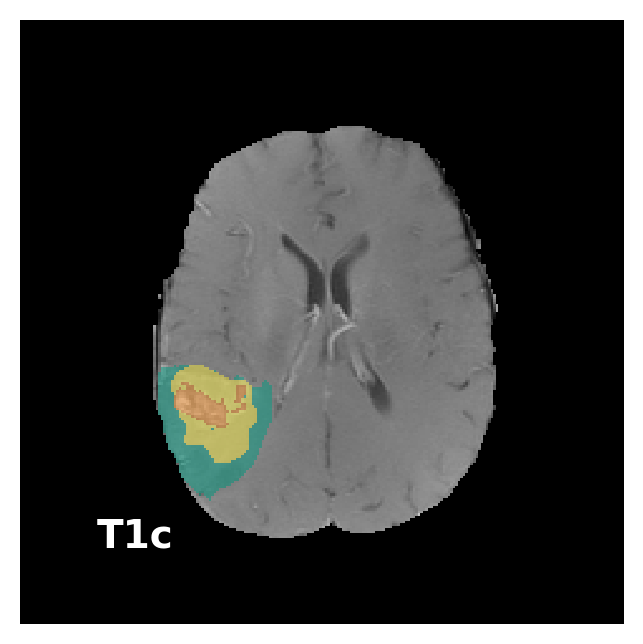

In [11]:
# self-contained plotting example with colormap
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

path_anat = '/Users/christoph/Documents/Uni/HiWi/IBBM/Testdata/one_raw/brats2016_test_tcia_pat454_0001/t1c.nii'
path_seg = '/Users/christoph/Documents/Uni/HiWi/IBBM/Testdata/one_gt/brats2016_test_tcia_pat454_0001/gt.nii'

alpha = 0.5
transparent = (0,0,0,0)
active = (0.95, 0.9, 0.25, 1.0) # yellow
necrosis = (0.8, 0.4, 0, 1.0) #kinda red/orange
edema = (0, 0.6, 0.5, 1.0) # bluish green
# set up colormap 
cmap = colors.ListedColormap([transparent, active, edema, necrosis])
# bounds between 0 and 1 to avoid reassignment of color channels to other labels when not all of them are present
bounds=[0,0.2,0.4,0.8,1] #divide seg labels by 5 to assign the right bins
norm = colors.BoundaryNorm(bounds, ncolors=4)

# load and convert gt and anat images
anat_img = nib.load(path_anat)
anat_img_data = anat_img.get_fdata()
seg_img = nib.load(path_seg)
seg_img_data = seg_img.get_fdata()
seg = np.zeros(seg_img_data.shape)
seg[seg_img_data == 2] = 2
seg[seg_img_data == 3] = 1
seg[seg_img_data == 4] = 4

# demo slice number 
slc=78 

# set up figure for plotting
fig = plt.figure(frameon=False)
plt.grid(b=None)
plt.axis('off')
fig.set_dpi(200)
# plot anat image 
plt.annotate('T1c', xy=(20,20), xytext=(30,30), color='white', weight='bold', size=14)
raw = plt.imshow(np.flip(np.flip(np.rot90(anat_img_data[:,:,slc])),0), cmap=plt.cm.gray, origin='lower')
plt.savefig('/Users/christoph/Downloads/test.png', transparent=True, bbox_inches='tight', pad_inches=0,dpi=200)
# plot overlay with segmentation
seg = plt.imshow(np.flip(np.flip(np.rot90(seg[:,:,slc])),0)/5, alpha=alpha, cmap=cmap, norm=norm, origin='lower')
plt.savefig('/Users/christoph/Downloads/test_seg.png', transparent=True, bbox_inches='tight', pad_inches=0,dpi=200)

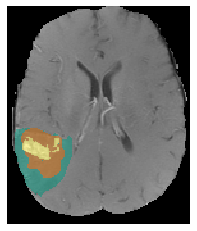

In [12]:
# plotting using individual layers for each label 
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

path_anat = '/Users/christoph/Documents/Uni/HiWi/IBBM/Testdata/one_raw/brats2016_test_tcia_pat454_0001/t1c.nii'
path_seg = '/Users/christoph/Documents/Uni/HiWi/IBBM/Testdata/one_gt/brats2016_test_tcia_pat454_0001/gt.nii'

alpha = 0.5
transparent = (0,0,0,0)
active = (0.95, 0.9, 0.25, 1.0) # yellow
necrosis = (0.8, 0.4, 0, 1.0) #kinda red/orange
edema = (0, 0.6, 0.5, 1.0) # bluish green
# set up colormaps
edm = colors.ListedColormap([transparent, edema])
atm = colors.ListedColormap([transparent, active])
necm = colors.ListedColormap([transparent, necrosis])

# load and convert gt and anat images
anat_img = nib.load(path_anat)
anat_img_data = anat_img.get_fdata()
seg_img = nib.load(path_seg)
seg_img_data = seg_img.get_fdata()
seg = np.zeros(seg_img_data.shape)
seg[seg_img_data == 2] = 2
seg[seg_img_data == 3] = 1
seg[seg_img_data == 4] = 4

# demo slice number 
slc=78 

# set up figure for plotting
fig = plt.figure(frameon=False)
plt.grid(b=None)
plt.axis('off')
#fig.set_dpi(200)
# plot anat image 
rmin, rmax, cmin, cmax, zmin, zmax = bbox(anat_img_data)
anat_img_data = anat_img_data[rmin:rmax,cmin:cmax, zmin:zmax]
seg = seg[rmin:rmax,cmin:cmax,zmin:zmax]
slc = slc-zmin
raw = plt.imshow(np.flip(np.flip(np.rot90(anat_img_data[:,:,slc])),0), cmap=plt.cm.gray, origin='lower')
#plt.annotate('T1c', xy=(20,20), xytext=(30,210), color='white', size=14)
plt.savefig('/Users/christoph/Downloads/test.png', transparent=True, bbox_inches='tight', pad_inches=0)
# plot overlay with segmentation
# create 2D layer for each label
ed = np.zeros(seg[:,:,slc].shape)
nec = np.zeros(seg[:,:,slc].shape)
act = np.zeros(seg[:,:,slc].shape)
ed[seg[:,:,slc] == 2] = 1
nec[seg[:,:,slc] == 1] = 1
act[seg[:,:,slc] == 4] = 1
plt.imshow(np.flip(np.flip(np.rot90(act)),0), cmap=atm, alpha=0.5, origin='lower')
plt.imshow(np.flip(np.flip(np.rot90(ed)),0), cmap=edm, alpha=0.5, origin='lower')
plt.imshow(np.flip(np.flip(np.rot90(nec)),0), cmap=necm, alpha=0.5, origin='lower')
#plt.show()
#seg = plt.imshow(np.flip(np.flip(np.rot90(seg[:,:,slc])),0)/5, alpha=alpha, cmap=cmap, norm=norm, origin='lower')
plt.savefig('/Users/christoph/Downloads/test_seg_'+str(slc)+'.png', transparent=True, bbox_inches='tight', pad_inches=0)